# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import json
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
# Set the style to "darkgrid"
sns.set_style('darkgrid')
sns.set_palette(["#39A7D0","#36ADA4"])
 

### 1b. Load the data
Call the variable `cigData`. 

In [6]:
# Define path for data
path = r'data/CowboyCigsData.csv'
# Read the data into dataframe
cigData = pd.read_csv(path, index_col=0)
print("Shape of the data ",cigData.shape,'\n')
print('Columns of DataFrame ',cigData.columns,'\n')
print("Information on database",cigData.info(),'\n')
cigData.head()

Shape of the data  (144, 2) 

Columns of DataFrame  Index(['Time', '#CigSales'], dtype='object') 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB
Information on database None 



,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [9]:
cigData.columns
# There are 2 columns and 144 rows of data.  Index is monthly date

Index(['Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [10]:
cigData.info()
# The index values are a column that is not named and shown as "Unnamed: 0"
# There are objects for time data - needs to be converted to datetime
# There are integers for sales values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Time       144 non-null    object
 1   #CigSales  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


Check whether there are any null values. 

In [11]:
cigData.isnull().sum()
# There are no null values

Time         0
#CigSales    0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [12]:
# Unnamed: 0 column was converted to index on read_csv with parameter
print(cigData.head())

      Time  #CigSales
0  1949-01    1000112
1  1949-02    1000118
2  1949-03    1000132
3  1949-04    1000129
4  1949-05    1000121


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [13]:
cigData.rename(columns= {'Time':'Month','#CigSales':'Sales'}, inplace=True)
cigData.head()

,Month,Sales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [14]:
cigData['Month'] = pd.to_datetime(cigData['Month'])
cigData.set_index('Month', inplace=True)

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

Check the type of our new variable. 

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
y = cigData['Sales']
result = seasonal_decompose(y, model='multiplicative')

print('shape of data: ',cigData.shape)
cigData.head(13)

print(type(y))
print(y)

shape of data:  (144, 1)
<class 'pandas.core.series.Series'>
Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
               ...   
1960-08-01    1000606
1960-09-01    1000508
1960-10-01    1000461
1960-11-01    1000390
1960-12-01    1000432
Name: Sales, Length: 144, dtype: int64


### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [18]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: Sales, dtype: float64

### 2f. Plotting `y`

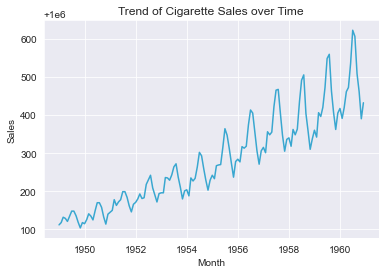

In [19]:
# Visualize the data
# Plot the sales as line graph with months in time as dependent variable
fig, ax = plt.subplots()
ax.plot(y.index,y)
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Trend of Cigarette Sales over Time')
plt.show()

## 3. Modelling 
### 3a. Decomposition

The plot shows a trend upwards over time, but also a cyclical annual pattern.  The season pattern shows sales increasing with peaks in months 7 and 8.  This could be a return to school/or fall impact that drives up sales.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Article reference: https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7

Based on the shaape of the data, it appears to be multiplicative.  The pattern is increasing and the rate is also increasing

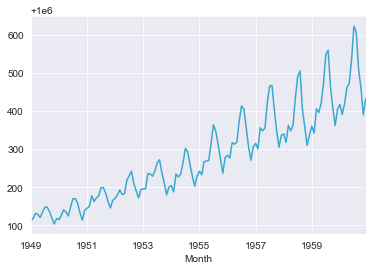

In [20]:
# To determine the difference between Additive and Multiplicative impacts from the seasonality
# Apply statsmodels analysis on the data
# Import seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose

# Decomposition applied to data series y 
decomposition = seasonal_decompose(y, model='multiplicative')
# Variables for trend, seasonal and residual components  
# Assign them the relevant features of decomposition 
#trend = decomposition.trend
#seasonal = decomposition.seasonal
#residual = decomposition.resid

# Plot the original data, the trend, the seasonality, and the residuals 
decomposition.observed.plot();

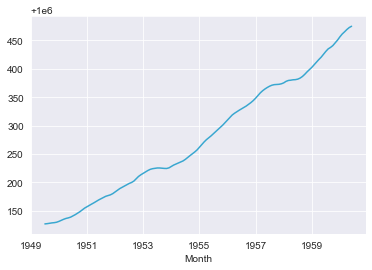

In [21]:
decomposition.trend.plot();

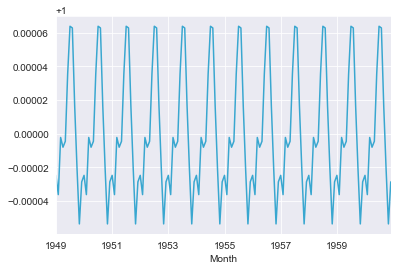

In [22]:
decomposition.seasonal.plot();

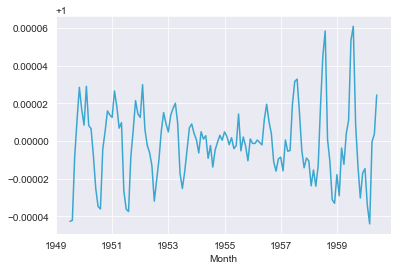

In [23]:
decomposition.resid.plot();

The Cowboy Cigarettes data has an increasing trend and has seasonality, as such it is multiplicative. 

### 3b. Testing for stationarity with KPSS
Check for stationarity. A stationary time series dataset will have constant mean, variance, and covariance.

Apply the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; look at *p*-value to be less than the significance level 0.05 then we reject the Null and infer that the data is not stationary.

In [84]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import kpss
# Null hypothesis: time series data is stationary

stats, p, lags, cv = kpss(y,'ct')

print('Test Statistics: ',stats)
print('P Value: ',p)
print('Critical Values: ',cv)

Test Statistics:  0.1627365740528083
P Value:  0.03605285495599307
Critical Values:  {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

### 3c. Making the data stationary 
Let's recall what it looks like. 

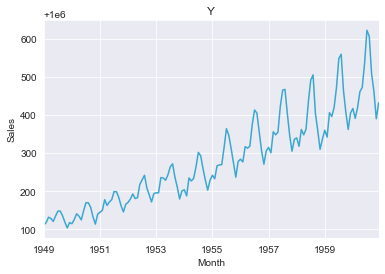

In [85]:
y.plot()
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Y')
plt.show()

In our plot, we can see that both the mean and the variance *increase as time progresses*. Now take the natural log of all the values in our dataset to see how it impacts stationarity. 

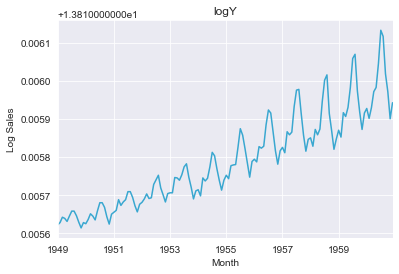

In [86]:
y_log = np.log(y)
y_log.plot()
plt.xlabel('Month')
plt.ylabel('Log Sales')
plt.title('logY')
plt.show()

Variance in our data now remains contant over time.

In [87]:
y_diff = y_log.diff().dropna()
stats, p, lags, cv = kpss(y_diff,'ct')

print('Test Statistics: ',stats)
print('P Value: ',p)
print('Critical Values: ',cv)

Test Statistics:  0.05330596083077197
P Value:  0.1
Critical Values:  {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}


P is above 0.05 at 0.1, We can accept null hypothesis that data is stationary

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [88]:
# Import mean_squared_error and ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [102]:
# Function to evaluate the ARIMA model
def evaluate_arima_model(X, arima_order):
    # Split dataset for train 80% and test 20%
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # Predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # Error
    error = mean_squared_error(test, predictions)
    return error


In [103]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    # set best score to float('inf') for infinately low value capture
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))


#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [104]:
# Choose values to try for each parameter.
p_values = [0,1,2]
d_values = [0,1,2]
q_values = [0,1,2]

In [105]:
# Find the optimum ARIMA model for our data.
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.000
ARIMA(0, 0, 1) MSE=0.000
ARIMA(0, 1, 0) MSE=0.000
ARIMA(0, 1, 1) MSE=0.000
ARIMA(0, 1, 2) MSE=0.000
ARIMA(0, 2, 0) MSE=0.000
ARIMA(0, 2, 1) MSE=0.000
ARIMA(0, 2, 2) MSE=0.000
ARIMA(1, 0, 0) MSE=0.000
ARIMA(1, 0, 1) MSE=0.000
ARIMA(1, 0, 2) MSE=0.000
ARIMA(1, 1, 0) MSE=0.000
ARIMA(1, 1, 1) MSE=0.000
ARIMA(1, 2, 0) MSE=0.000
ARIMA(2, 0, 0) MSE=0.000
ARIMA(2, 0, 1) MSE=0.000
ARIMA(2, 1, 0) MSE=0.000
ARIMA(2, 1, 1) MSE=0.000
ARIMA(2, 1, 2) MSE=0.000
ARIMA(2, 2, 0) MSE=0.000
ARIMA(2, 2, 2) MSE=0.000
Best ARIMA(2, 1, 1) MSE=0.000


So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [106]:
# call ARIMA with order set to 2,1,1
model = ARIMA(y_log, order=(2,1,1))
model_fit = model.fit()
forecast = model_fit.forecast(24)

We can take a look at a summary of the model this library has built around our data.

In [107]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  143
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1263.116
Method:                       css-mle   S.D. of innovations              0.000
Date:                Fri, 27 Aug 2021   AIC                          -2516.233
Time:                        10:16:54   BIC                          -2501.418
Sample:                    02-01-1949   HQIC                         -2510.213
                         - 12-01-1960                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.624e-06   5.06e-07      5.184      0.000    1.63e-06    3.62e-06
ar.L1.D.Sales     0.4681      0.156      3.003      0.003       0.163       0.774
ar.L2.D.Sales    -0.2640      0.109     -2.413      0.016      -0.478      -0.050
ma.L1.D.Sales    -0.8693        nan        nan        nan         nan         nan
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.8866           -1.7326j            1.9463           -0.1747
AR.2            0.8866           +1.7326j            1.9463            0.1747
MA.1            1.1504           +0.0000j            1.1504            0.0000
-----------------------------------------------------------------------------
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

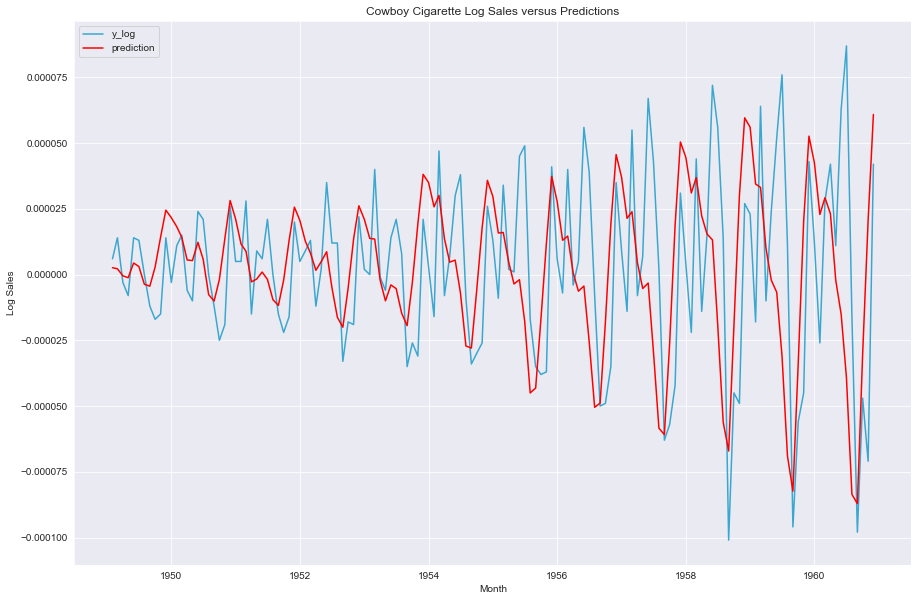

In [111]:
plt.figure(figsize=(15,10))
plt.plot(y_log.diff(), label='y_log')
plt.plot(model_fit.predict(), color='red', label='prediction')
plt.xlabel('Month')
plt.ylabel('Log Sales')
plt.title('Cowboy Cigarette Log Sales versus Predictions')
plt.legend()
plt.show()

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

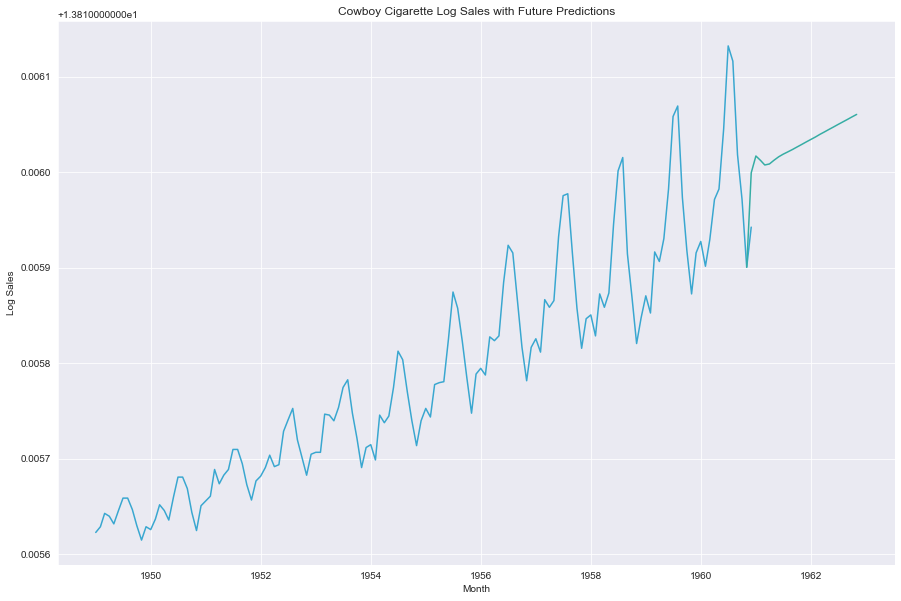

In [115]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast
forecast_period = 24
date_range = pd.date_range(y_log.index[-1], periods = forecast_period,
                          freq='MS').strftime('%Y-%m-%d').tolist()

# Convert that range into a dataframe that includes your predictions
future_months = pd.DataFrame(date_range, columns = ['Month'])

# convert 'Month' to datetime object
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace=True)
future_months['Prediction']=forecast[0]

# Plot y log with future predictions
plt.figure(figsize=(15,10))
plt.plot(y_log)
plt.plot(y_log['Nov 1960'].append(future_months['Prediction']))
plt.xlabel('Month')
plt.ylabel('Log Sales')
plt.title('Cowboy Cigarette Log Sales with Future Predictions')
plt.show()


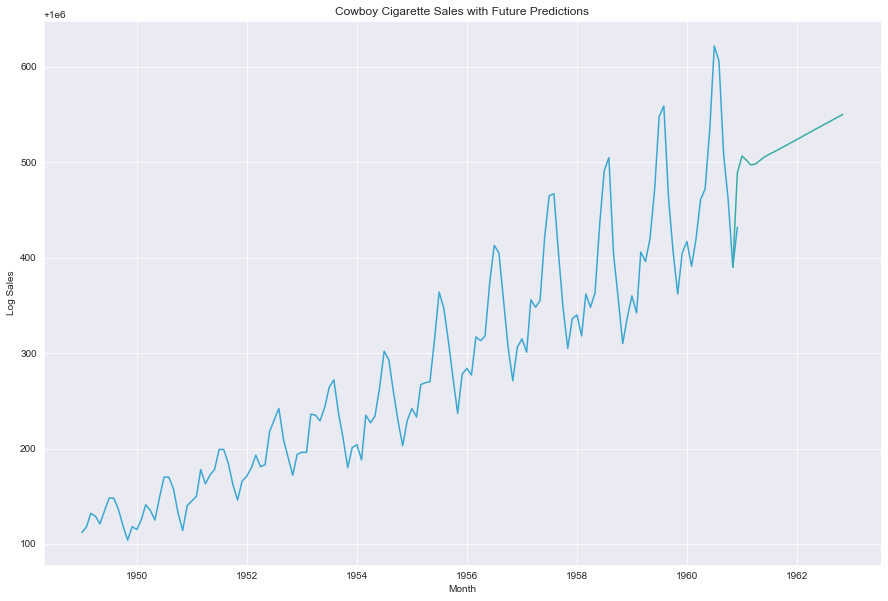

In [117]:
# Plot original sales with future predictions
plt.figure(figsize=(15,10))
plt.plot(y,)
plt.plot(np.exp(y_log['Nov 1960'].append(future_months['Prediction'])))
plt.xlabel('Month')
plt.ylabel('Log Sales')
plt.title('Cowboy Cigarette Sales with Future Predictions')
plt.show()

## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 